In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn")

#### Load and inspect data

In [12]:
df_test = pd.read_csv("data/sag_data_test.csv", index_col="Time", parse_dates=True)

In [126]:
df_test.head()

,Bearing Pressure (kPa),Power Draw (MW),Speed (RPM),Dilution Flow Rate (m3/h),Conveyor Belt Feed Rate (t/h),Conveyor Belt PSD Fines (%)
Time,,,,,,
2015-12-21 00:00:00,5364.649789,12.762004,8.073871,1073.169397,2940.881221,40.390537
2015-12-21 00:01:00,5343.775163,12.491533,7.889129,1057.823776,3042.468414,44.751640
2015-12-21 00:02:00,5350.858199,12.290888,7.970280,1036.836364,2959.495635,42.130604
2015-12-21 00:03:00,5361.138694,12.786268,8.288696,1054.944698,2994.353878,38.415417
2015-12-21 00:04:00,5294.834751,13.010269,8.281600,1084.639678,2951.411343,45.020363


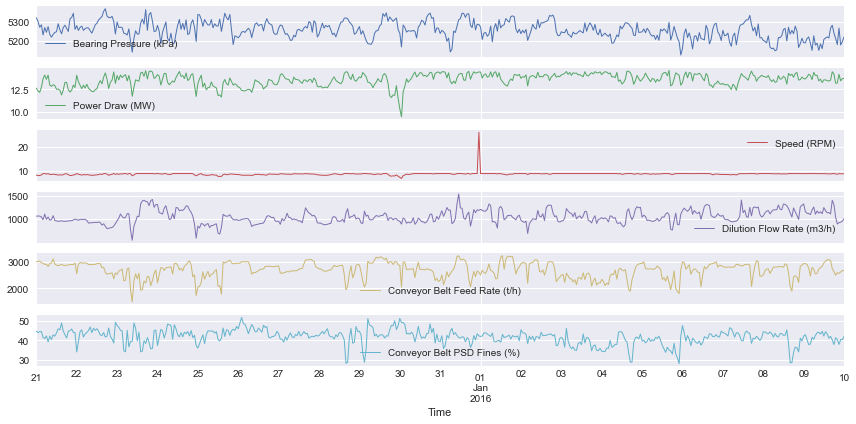

In [111]:
df_test.resample("h").median().plot(subplots=True, layout=(-1, 1), lw=1, figsize=(12, 6))
plt.tight_layout()

#### Define target columns

In [14]:
target_cols = ['Bearing Pressure (kPa)', 'Power Draw (MW)']

#### Baseline
As the baseline, we will use a "model" that simply predicts that the last value will remain constant over the next five minutes.

In [15]:
actual = df_test[target_cols].shift(5)
predicted = df_test[target_cols]
errors = predicted - actual

#### Calculate RMSE for the constant predictions.

In [16]:
rmse = (errors**2).mean()**0.5
rmse

Bearing Pressure (kPa)    44.384918
Power Draw (MW)            0.480964
dtype: float64

#### Error histograms

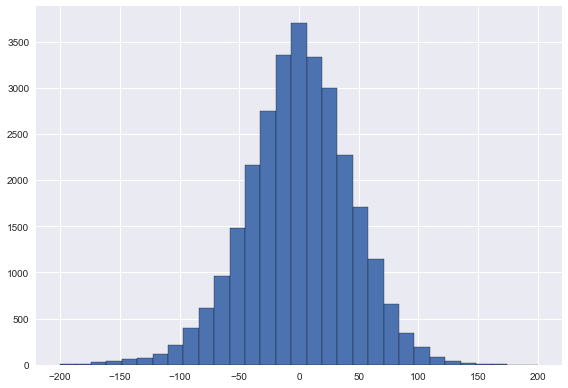

In [17]:
errors['Bearing Pressure (kPa)'].hist(bins=31, range=(-200, 200), edgecolor="k")
plt.tight_layout()

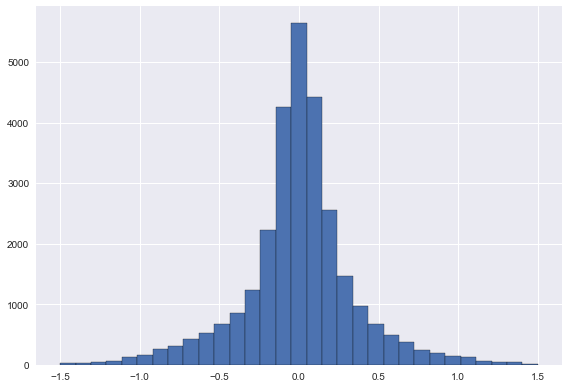

In [18]:
errors['Power Draw (MW)'].hist(bins=31, range=(-1.5, 1.5), edgecolor="k")
plt.tight_layout()

In [167]:
print(df_test.info())
print('-----------------------\n')
print(df_test.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28801 entries, 2015-12-21 00:00:00 to 2016-01-10 00:00:00
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Bearing Pressure (kPa)         28801 non-null  float64
 1   Power Draw (MW)                28801 non-null  float64
 2   Speed (RPM)                    28801 non-null  float64
 3   Dilution Flow Rate (m3/h)      28801 non-null  float64
 4   Conveyor Belt Feed Rate (t/h)  28801 non-null  float64
 5   Conveyor Belt PSD Fines (%)    28801 non-null  float64
dtypes: float64(6)
memory usage: 1.5 MB
None
-----------------------

       Bearing Pressure (kPa)  Power Draw (MW)   Speed (RPM)  \
count            28801.000000     28801.000000  28801.000000   
mean              5258.846880        13.560647      8.520870   
std                 58.470221         0.937158      0.978093   
min               4964.385379        -0.022015     

In [172]:
df_train = pd.read_csv("data/sag_data_train.csv", index_col="Time", parse_dates=True)
print(df_train.info())
print('-----------------------\n')
print(df_train.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138241 entries, 2015-09-15 00:00:00 to 2015-12-20 00:00:00
Data columns (total 6 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Bearing Pressure (kPa)         138240 non-null  float64
 1   Power Draw (MW)                138240 non-null  float64
 2   Speed (RPM)                    138241 non-null  float64
 3   Dilution Flow Rate (m3/h)      138239 non-null  float64
 4   Conveyor Belt Feed Rate (t/h)  138239 non-null  float64
 5   Conveyor Belt PSD Fines (%)    138239 non-null  float64
dtypes: float64(6)
memory usage: 7.4 MB
None
-----------------------

       Bearing Pressure (kPa)  Power Draw (MW)    Speed (RPM)  \
count           138240.000000    138240.000000  138241.000000   
mean              5361.525046        12.648002       8.010549   
std                202.317899         2.680285       1.617348   
min                 35.651295        -

In [174]:
df_train = df_train.interpolate()

In [176]:
df_train.columns[0]

'Bearing Pressure (kPa)'

In [177]:
from statsmodels.tsa.stattools import adfuller

for colname in df_train.columns:
    print('Results of Dickey-Fuller Test for {}:'.format(colname))
    dftest = adfuller(df_train[colname], autolag = 'AIC')

    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print(dfoutput)

Results of Dickey-Fuller Test for Bearing Pressure (kPa):
Test Statistic                    -22.747062
p-value                             0.000000
#Lags Used                         73.000000
Number of Observations Used    138167.000000
Critical Value (1%)                -3.430397
Critical Value (5%)                -2.861561
Critical Value (10%)               -2.566781
dtype: float64
Results of Dickey-Fuller Test for Power Draw (MW):
Test Statistic                -1.543702e+01
p-value                        2.898108e-28
#Lags Used                     3.600000e+01
Number of Observations Used    1.382040e+05
Critical Value (1%)           -3.430397e+00
Critical Value (5%)           -2.861561e+00
Critical Value (10%)          -2.566781e+00
dtype: float64
Results of Dickey-Fuller Test for Speed (RPM):
Test Statistic                -1.497000e+01
p-value                        1.204110e-27
#Lags Used                     3.600000e+01
Number of Observations Used    1.382040e+05
Critical Value 

<AxesSubplot:xlabel='Time'>

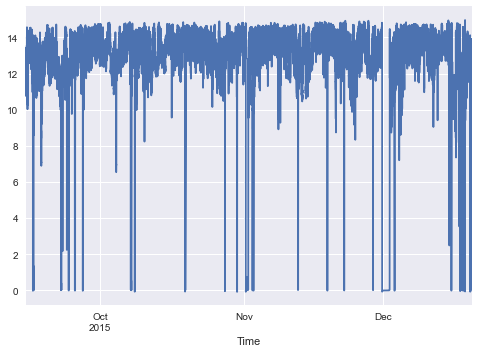

In [185]:
df_train_hourly = df_train.resample('H').mean()

df_train['Power Draw (MW)'].plot()


<AxesSubplot:xlabel='Time'>

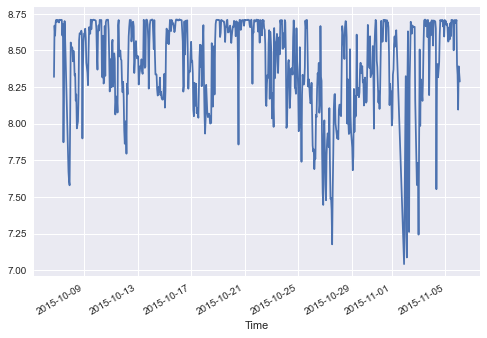

In [164]:
mask = df_train_hourly['Speed (RPM)'] < 7
df_train_hourly_without = df_train_hourly[~mask]
df_train_hourly_without.iloc[500:1200]['Speed (RPM)'].plot()

Results of Dickey-Fuller Test:
Test Statistic                -1.543702e+01
p-value                        2.898108e-28
#Lags Used                     3.600000e+01
Number of Observations Used    1.382040e+05
Critical Value (1%)           -3.430397e+00
Critical Value (5%)           -2.861561e+00
Critical Value (10%)          -2.566781e+00
dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x13ef67a90>,
 'caps': [<matplotlib.lines.Line2D at 0x13ef76190>,
 'boxes': [<matplotlib.lines.Line2D at 0x13ef67730>],
 'medians': [<matplotlib.lines.Line2D at 0x13ef76820>],
 'fliers': [<matplotlib.lines.Line2D at 0x13ef76b50>],
 'means': []}

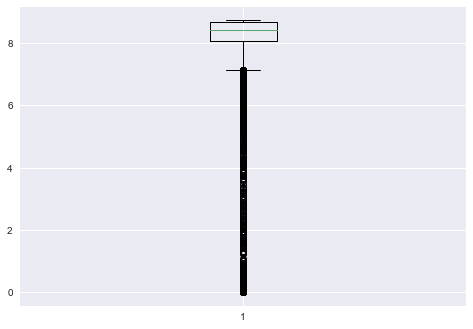

In [165]:
plt.boxplot(df_train['Speed (RPM)'])

In [75]:
df_train['Power Draw (MW)']

Time
2015-09-15 00:00:00    11.737357
2015-09-15 00:01:00    11.543755
2015-09-15 00:02:00    11.169525
2015-09-15 00:03:00    11.035091
2015-09-15 00:04:00    11.418827
                         ...    
2015-12-19 23:56:00    13.661863
2015-12-19 23:57:00    13.610935
2015-12-19 23:58:00    13.392879
2015-12-19 23:59:00    13.103755
2015-12-20 00:00:00    13.024095
Name: Power Draw (MW), Length: 138241, dtype: float64

In [108]:
df_test

,Bearing Pressure (kPa),Power Draw (MW),Speed (RPM),Dilution Flow Rate (m3/h),Conveyor Belt Feed Rate (t/h),Conveyor Belt PSD Fines (%)
Time,,,,,,
2015-12-21 00:00:00,5364.649789,12.762004,8.073871,1073.169397,2940.881221,40.390537
2015-12-21 00:01:00,5343.775163,12.491533,7.889129,1057.823776,3042.468414,44.751640
2015-12-21 00:02:00,5350.858199,12.290888,7.970280,1036.836364,2959.495635,42.130604
2015-12-21 00:03:00,5361.138694,12.786268,8.288696,1054.944698,2994.353878,38.415417
2015-12-21 00:04:00,5294.834751,13.010269,8.281600,1084.639678,2951.411343,45.020363
...,...,...,...,...,...,...
2016-01-09 23:56:00,5180.447236,13.889173,8.609995,1052.922543,2695.421540,40.853775
2016-01-09 23:57:00,5182.558287,13.845209,8.607400,1065.426875,2640.853654,40.898125
2016-01-09 23:58:00,5226.243211,13.705972,8.604805,1075.829229,2669.391060,41.102623


<ipython-input-118-2e247740f7b5>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df_test['2016-01-06']['Power Draw (MW)'].plot()


<AxesSubplot:xlabel='Time'>

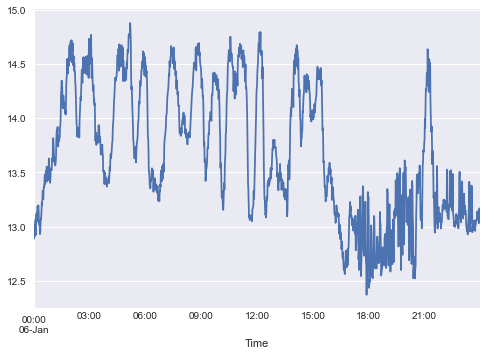

In [118]:
df_test['2016-01-06']['Power Draw (MW)'].plot()

# Model

In [ ]:
powerdr = df_trai

In [178]:
def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

In [179]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)
X1.shape, y1.shape

NameError: name 'temp' is not defined